<a href="https://colab.research.google.com/github/littlejacinthe/Audio_NeuralStyle/blob/master/Audio_Style_Transfer_nnSTFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code from 

https://github.com/muhdhuz/Audio_NeuralStyle

https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

https://github.com/DmitryUlyanov/neural-style-audio-tf

In [1]:
! pip install nnAudio==0.3.1
! pip install "ray[tune]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%matplotlib inline

In [3]:
# import libraries

import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import librosa
import librosa.display
from IPython.display import Audio, display
from PIL import Image
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import soundfile as sf

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.nn.modules.module import _addindent

from nnAudio import features
from nnAudio.Spectrogram import *
from scipy.io import wavfile

import copy
import os
import math
import collections as c

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

/usr/local/lib/python3.9/dist-packages/nnAudio/Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(


In [4]:
#use GPU and put tensors on CUDA if possible

use_cuda = torch.cuda.is_available() # check if GPU is available
print('GPU available =',use_cuda)
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor # use CUDA tensors if GPU available, otherwise just float tensors

GPU available = True


In [5]:
! mkdir output

mkdir: cannot create directory ‘output’: File exists


In [6]:
# parameters

#I/O
style_path = '/content/style_0.wav' # path to style audio file
content_path = '/content/content_0.wav' # path to content audio file
out_dir = "output" # path to output directory
out_name = "out" # name of output file
num_out = 1 # number of outputs
input_type = "spec" # input audio as wav, spectrogram or CQT
gen_type = "content" # choose to generate sound from noise or the content input

# audio parameters
sr = 22050 # sample rate

# spectrogram parameters
fft = 2048
win_len = None
freq_bin = fft // 2+1
hop_len = None
win = 'hann'
freq_Sc = 'no'
center = True
padd = 'reflect'
f_min = 50
f_max = 6000
train = True
out_form = 'Complex'
verb = True


# other parameters
usescale = False # use [0,1] scale for input
boundopt = False # regularize input within [lower, upper]
num_filters = 4096 # number of input filters in the network
kernel = 3 # width of the convolution filter
pad = 1 #(kernel-1)//2
lr = 0.1 # learning rate
steps = 500 # number of time we update the parameters of the generated image
style_weight = 10000 # amount of style we want in the output
content_weight = 1 # amount of content we want in the output
content_layer = ['relu_1'] # choose which layer to use for content loss
style_layer = ['relu_3'] # choose which layer to use for style loss
index = 1

In [7]:
config = {
    "gen_type": tune.choice(["content", "noise"]), # choose to generate sound from noise or the content input

    # spectrogram parameters
    "fft": tune.choice([2048, 1024, 512]),
    "win_len": tune.choice([None, 2048, 1024, 512]),
    "freq_bin": tune.choice([2048, 1024, 512, 256]),
    "hop_len": tune.choice([None, 2048, 1024, 512, 256]),
    "win": tune.choice(['hann', 'hamming', 'gaussian']),
    "freq_Sc": tune.choice(['linear', 'log', 'log2', 'no']),
    "center": tune.choice([True, False]),
    "padd": tune.choice(['reflect']),
    "pad_amt": tune.choice([1024, 512, 256]),
    "f_min": tune.choice([50, 'no']),
    "f_max": tune.choice([6000, 'no']),
    "train": tune.choice([True, False]),
    "out_form": tune.choice(['Complex', 'Magnitude', 'Phase']),
    "verb": tune.choice([True, False]),


    # other parameters
    "usescale": tune.choice([True, False]), # use [0,1] scale for input
    "boundopt": tune.choice([True, False]), # regularize input within [lower, upper]
    "num_filters": tune.choice([4096, 8192, 2048, 1024, 512, 256]), # number of input filters in the network
    "kernel": tune.choice([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]), # width of the convolution filter
    "pad": tune.choice([1, 2, 3]), #(kernel-1)//2
    "steps": tune.choice([100, 200, 300, 400, 500, 600]),  # number of time we update the parameters of the generated image
    "style_weight": tune.sample_from(lambda _: 10**np.random.randint(0, 4)), # amount of style we want in the output
    "content_weight": tune.sample_from(lambda _: 10**np.random.randint(0, 4)), # amount of content we want in the output
    "content_layer": tune.choice(['STFT', 'conv1', 'conv2', 'conv3', 'bachtnorm1', 'batchnorm2', 'batchnorm3' ,'relu_1']), # choose which layer to use for content loss
    "style_layer": tune.choice(['STFT', 'conv1', 'conv2', 'conv3', 'bachtnorm1', 'batchnorm2', 'batchnorm3' ,'relu_1']), # choose which layer to use for style loss
    "index": tune.choice([1, 2, 3]),
    "reg_weight": tune.choice([0.1, 1, 10])
}

In [8]:
# display style and content audio to check

display(Audio(style_path))
display(Audio(content_path))

In [9]:
# preprocessing methods with nnAudio.Spectrogram

def wav(filename):
    samplerate, x = wavfile.read(filename) # x = audio data, sr = sample rate
    x = torch.tensor(x).type(dtype)
    return x


In [10]:
# display 

def display_spec(spec):
  spec = spec.cpu()
  spec = torch.squeeze(spec, 0)
  fig, ax = plt.subplots()
  spec = librosa.amplitude_to_db(np.abs(spec), ref=np.max)
  img = librosa.display.specshow(spec, sr=sr, hop_length=hop_len, y_axis='log', x_axis='time', ax=ax)
  ax.set_title('Spectrogram')
  fig.colorbar(img, ax=ax, format="%+2.0f dB")

def display_wav(wav):
  wav = wav.cpu()
  wav = wav.numpy()
  fig, ax = plt.subplots()
  librosa.display.waveshow(wav, sr=sr, ax=ax)
  ax.set(title='Waveform view, stereo')
  ax.label_outer()

In [11]:
# post processing methods with nnAudio.Spectrogram
def out_wav(index, x):
    x = x.cpu()
    sf.write(out_dir + '/' + out_name + '_' + str(index) + '.wav', x, sr)

wav shape:  torch.Size([661504])


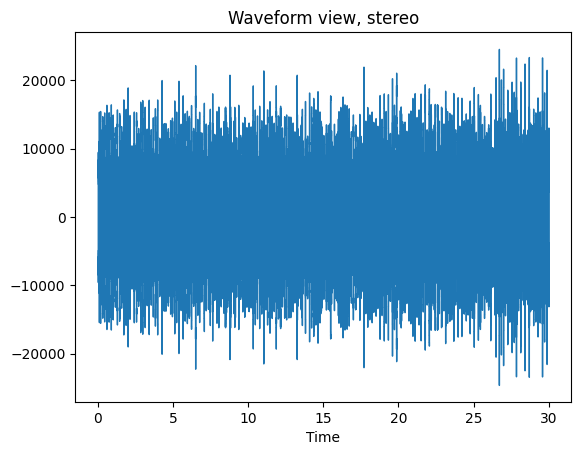

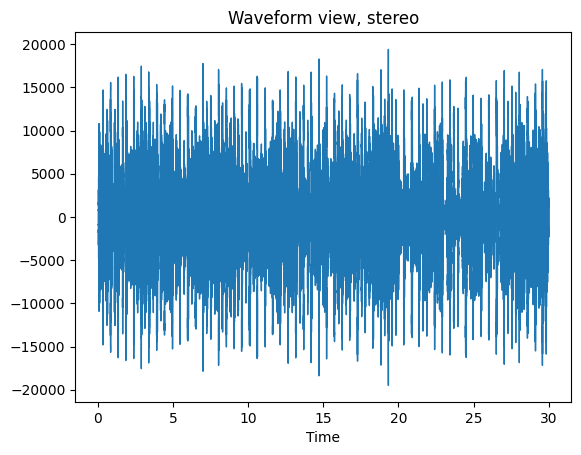

In [12]:
content_wav = wav(content_path) # get spectrogram
style_wav = wav(style_path)
display_wav(content_wav)
display_wav(style_wav)
print("wav shape: ", content_wav.shape)

In [13]:
# initialize weights for the neural network

def weights_init(m):
  std = np.sqrt(2) * np.sqrt(2.0 / ((config["freq_bin"] + config["num_filters"]) * config["kernel"]))
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    m.weight.data.normal_(0.0,std)

In [16]:
# Neural Network 

class NeuralNetwork(nn.Module): 
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(c.OrderedDict([
            ('STFT', features.STFT(n_fft=2048, win_length=config["win_len"], freq_bins=config["freq_bin"], hop_length=config["hop_len"], window=config["win"], 
                                   freq_scale=config["freq_Sc"], center=True, fmin=config["f_min"], fmax=config["f_max"], sr=sr, 
                                   trainable=config["train"], output_format=config["out_form"], verbose=config["verb"])),
            ('conv1',nn.Conv2d(in_channels=config["freq_bin"], out_channels=config["num_filters"], kernel_size=(1, config["kernel"]), padding=config["pad"], bias=True)),
            ('batchnorm1',nn.BatchNorm2d(config["num_filters"])),
            ('relu1',nn.ReLU()),
            ('conv2', nn.Conv2d(in_channels=config["num_filters"], out_channels=1, kernel_size=(1, config["kernel"]), padding=config["pad"], bias=False)),
            ('batchnorm2',nn.BatchNorm2d(1)),
            ('relu2',nn.ReLU()),
            ('conv3', nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1, config["kernel"]), padding=config["pad"], bias=False)),
            ('batchnorm3',nn.BatchNorm2d(1)),
            ('relu3',nn.ReLU())]))
        
    def forward(self,input):
        out = self.layers(input)
        return out

model = NeuralNetwork() # initialize model
model.apply(weights_init)
#model.eval()

for param in model.parameters():
    param.requires_grad = False # model parameters do not need to be updated, we will optimize noise instead

if use_cuda == True:
  model.cuda() # put model on GPU

TypeError: ignored

In [ ]:
# Content loss

class ContentLoss(nn.Module):

    def __init__(self, target, weight): #weight here is the amount of content we want in the model
        super(ContentLoss, self).__init__()
        # from Pytorch doc :
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target) # use weight to bias the loss into using more or less content
        self.output = input
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_graph=retain_variables)
        return self.loss

In [ ]:
# Gram Matrix

class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size() #a=batch size(1), b=number of feature maps(4096), (c,d)=dimensions of a feat. map (c*d) 
        #features = input.view(a * b, c * d)  
        features = input.view(b, a * c * d)  # flatten

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * c * d) 

In [ ]:
# Style loss

class StyleLoss(nn.Module):

    def __init__(self, target, weight): # weight here is the amount of style we want in the model
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()   #(size_average=False) 

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.Gtarget = self.gram(self.target)
        self.loss = self.criterion(self.G, self.Gtarget) # target=gram matrix of the style image, G= gram matrix of the current input (noise)
        return self.output

    def backward(self, retain_variables=True):
        self.loss.backward(retain_graph=retain_variables)
        return self.loss

In [ ]:
# Initialize generated spectrum as noise or content input
input_wavs = []

if gen_type == "noise":
  input_wavs.append(Variable(torch.randn(content_wav.shape)*1e-3).type(dtype))
  #print("input shape", input_spec.shape)

if gen_type == "content":
  input_wavs.append(Variable(content_wav.clone().type(dtype)))#.contiguous()))
  #print("input shape", input_spec.shape)

input_wav = input_wavs[0]

In [ ]:
# Optimizer 

def optimizer(input):
    input_param = nn.Parameter(input.data)
    optimizer = optim.LBFGS([input_param])
    return optimizer, input_param

In [ ]:
# Regulator for the optimizer's weights

class opt_reg(nn.Module):

    def __init__(self, upper, lower, weight): #weight here is the how much of the noise input we want
        super(opt_reg, self).__init__()
        self.upper = Variable(dtype([upper]))
        self.lower = Variable(dtype([lower]))
        self.weight = weight

    def forward(self, input):
        self.zeros = Variable(torch.zeros(input.size()).type(dtype)) # generate variable of zeros of same size as the input 
                              
        self.over = torch.max(input-self.upper,self.zeros) # 
        self.under = torch.max(self.lower-input,self.zeros) 

        self.total= self.over + self.under
        self.l2total = self.weight * self.total.norm(2)
        return self.l2total

In [ ]:
# pick content and style layers we want to use in our network and compute content and style loss

def get_losses(model, style_input, content_input, content_layer, style_layer):

  model = copy.deepcopy(model)

  content_losses = [] # so we can iterate over losses later
  style_losses = [] 
  
  net = nn.Sequential() # new Sequential to put in the right number of layers
  layer_list = list(model.layers)  # get layer list from model
  
  # put the net on GPU if there is one
  if use_cuda:
        net = net.cuda()
        style_input = style_input.type(dtype)
        content_input = content_input.type(dtype)
   
  i = 1
  for layer in layer_list: # for each layer in the net
        if isinstance(layer, features.STFT): #if it is an STFT layer
        
            name = "STFT_" + str(i) # give it a name and a number so we can pick it out later
            net.add_module(name, layer) # add this layer to the model
            
            if content_input is not None: # if we are using content loss
                if name in content_layer: # if the name of the content layer is the one of the layer we chose to use
                    # add content loss:
                    target = net(content_input).clone() # make the content input go through the model until this layer
                    content_loss = ContentLoss(target, config["content_weight"]) # give the content representation as target of the content loss
                    net.add_module("content_loss_" + str(i), content_loss) # add the content loss to the net
                    content_losses.append(content_loss)

            if name in style_layer: # if the name of the style layer is the one of the layer we chose to use
                # add style loss:
                target_feature = net(style_input).clone() # make the style input go through the model until this layer
                style_loss = StyleLoss(target_feature, config["style_weight"]) # give the style representation as target of the style loss
                net.add_module("style_loss_" + str(i), style_loss) # add the style loss to the net
                style_losses.append(style_loss)

        if isinstance(layer, nn.Conv2d): #if it is a convolution layer
        
            name = "conv_" + str(i) # give it a name and a number so we can pick it out later
            net.add_module(name, layer) # add this layer to the model
            #print("net", net) 
            
            if content_input is not None: # if we are using content loss
                if name in content_layer: # if the name of the content layer is the one of the layer we chose to use
                    # add content loss:
                    target = net(content_input).clone() # make the content input go through the model until this layer
                    content_loss = ContentLoss(target, config["content_weight"]) # give the content representation as target of the content loss
                    net.add_module("content_loss_" + str(i), content_loss) # add the content loss to the net
                    content_losses.append(content_loss)

            if name in style_layer: # if the name of the style layer is the one of the layer we chose to use
                # add style loss:
                target_feature = net(style_input).clone() # make the style input go through the model until this layer
                style_loss = StyleLoss(target_feature, config["style_weight"]) # give the style representation as target of the style loss
                net.add_module("style_loss_" + str(i), style_loss) # add the style loss to the net
                style_losses.append(style_loss)

        if isinstance(layer, nn.ReLU): # do the same for ReLUs
            name = "relu_" + str(i)
            net.add_module(name, layer)
            #print(net)
            
            if content_input is not None:

              if name in content_layer:
                target = net(content_input).clone()
                content_loss = ContentLoss(target, config["content_weight"])
                net.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layer:
              # add style loss:
              target_feature = net(style_input).clone()
              style_loss = StyleLoss(target_feature, config["style_weight"])
              net.add_module("style_loss_" + str(i), style_loss)
              style_losses.append(style_loss)
            
        if isinstance(layer, nn.BatchNorm2d): # do the same for batchnorm
            name = "batchnorm_" + str(i)
            net.add_module(name, layer)
            
            if content_input is not None:
                if name in content_layer:
                    # add content loss:
                    target = net(content_input).clone()
                    content_loss = ContentLoss(target, config["content_weight"])
                    net.add_module("content_loss_" + str(i), content_loss)
                    content_losses.append(content_loss)
            
            if name in style_layer:
                # add style loss:
                target_feature = net(style_input).clone()
                style_loss = StyleLoss(target_feature, config["style_weight"])
                net.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)
                
            i += 1

  print("style loss", style_losses, "content loss", content_losses)
  return net, style_losses, content_losses

In [ ]:
# Training function

def transfer(model, style_input, content_input, input, steps, checkpoint_dir):

  print('Building model...')

  model, style_losses, content_losses = get_losses(model, style_input, content_input, content_layer, style_layer) # get network, style and content losses


  if boundopt == True:
        bound = opt_reg(1,0,weight=config["reg_weight"]) # regulate optimizer weights 

  optim, input_param = optimizer(input_wav)

  if checkpoint_dir:
          model_state, optimizer_state = torch.load(
              os.path.join(checkpoint_dir, "checkpoint"))
          model.load_state_dict(model_state)
          optimizer.load_state_dict(optimizer_state)

  print('Optimizing..')
  run = [0]
  while run[0] <= steps:
    def closure():

      optim.zero_grad()
      model(input_param) # generated spec goes through the model
      style_score = 0
      content_score = 0

      if boundopt == True:
        bound.zero_grad()
        reg = bound(input_param)
        if not torch.equal(reg.data,dtype([0])):
          reg.backward()

      for sl in style_losses:
        style_score += sl.backward() # call backward method to grab the loss
            
      if content_input is not None:
        for cl in content_losses:
          content_score += cl.backward()

          if boundopt == True:
            total_loss = style_score + reg + content_score
          else:
            total_loss = style_score + content_score
                    
      else:            
        if boundopt == True:
            total_loss = style_score + reg
        else:
            total_loss = style_score

      if run[0] % 50 == 0:              
                
        print("run {}:".format(run))
        print('Style Loss : {:4f}'.format(style_score))
        if content_input is not None: 
          print('Content Loss : {:4f}'.format(content_score))
        if boundopt == True:
          print('Bound Loss : {:4f}'.format(reg))
          print(torch.max(input_param.data),torch.min(input_param.data))
        print('Total Loss : {:4f}'.format(total_loss))

      run[0] += 1                  
      return total_loss   
        
    optim.step(closure)
    out = out_wav(index=run, x=input_param.data)

    with tune.checkpoint_dir(steps) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)
    tune.report(loss=(closure.total_loss / steps))
      
  return input_param.data

In [ ]:
output = transfer(model, style_wav, content_wav, input_wav, config["steps"])

In [ ]:
out = out_wav(index=1, x=output)

In [ ]:
display(Audio('output/out_1.wav'))

In [ ]:
def main(num_samples=10):

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        parameter_columns=["gen_type", "fft", "freq_bin", "win", "freq_Sc", "center", "train", "out_form", "verb", "usescale", "boundopt", "num_filters", "kernel",
                           "pad", "steps", "style_weight", "content_weight", "content_layer", "style_layer", "index", "reg_weight"]
        metric_columns=["loss", "training_iteration"])
    result = tune.run(
        partial(transfer),
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = model(best_trial.config["gen_type"], best_trial.config["fft"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=10, max_num_epochs=10, gpus_per_trial=0)